# Monitoring Water Quality

Clorophyll and Turbidity

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/products/s2_l2a)

## Background
Inland waterbodies are essential for supporting human life, both through the supply of drinking water and the support of agriculture and aquaculture.
Such waterbodies can be contaminated by [urban pollutants](https://www.ghanaweb.com/GhanaHomePage/NewsArchive/Lake-Bosumtwi-Dying-From-Pollution-159303) from the communities living nearby, causing health issues for people and animals. 
While the health of waterbodies can be monitored from the ground through sampling, satellite imagery can complement this.
One particular event that is related to poor water quality is the presence of algal blooms.
Specifically, waters with high levels of nutrients from fertilizers, sewage or urban runoff can host large algal blooms.
However, there needs to be a well-understood and tested way to link satellite observations to the presence of algal blooms.

### Sentinel-2 use case
Algal blooms are associated with the presence of chlorophyll-*a* in waterbodies.
[Mishra and Mishra (2012)](https://doi.org/10.1016/j.rse.2011.10.016) developed the normalised difference chlorophyll index (NDCI), which serves as a qualitative indicator for the concentration of clorophyll-*a* on the surface of a waterbody.
The index requires information from a specific part of the infrared specturm, known as the 'red edge'. 
This is captured as part of Sentinel-2's 13 spectral bands, making it possible to measure the NDCI with Sentinel-2. 

## Description

In this example, we measure the NDCI for Lake Bosomtwe, which is getting affected by the pollution as mentioned in the Background section.
This is combined with information about the size of the waterbody, which is used to build a helpful visualisation of how the water-level and presence of chlorophyll-*a* changes over time.
The worked example takes users through the code required to:

1. Load cloud-free Sentinel-2 images for an area of interest.
2. Compute indices to measure the presence of water and clorophyll-*a*.
3. Generate informative visualisations to identify the presence of clorophyll-*a*.

### Some caveats

* The NDCI is currently treated as an experimental index for Sentinel-2 sensors, as futher work is needed to calibrate and validate how well the index relates to the presence of clorophyll-*a*. 
* It is also important to remember that algal blooms will usually result in increased values of the NDCI, but not all NDCI increases will be from algal blooms.
For example, there may be seasonal fluctuations in the amount of clorophyll-*a* in a waterbody.
* Further validation work is required to understand how shallow water and atmospheric effects affect the NDCI, and its use in identifying high concentrations of clorophyll-*a*.

***

## Getting started

**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import sys
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

from geopy.geocoders import Nominatim 
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from deafrica_tools.plotting import display_map, map_shapefile, rgb
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.dask import create_local_dask_cluster
from datacube.utils.geometry import Geometry
from deafrica_tools.spatial import xr_rasterize

import matplotlib.colors as mcolors
from matplotlib_scalebar.scalebar import ScaleBar 


/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


### Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:42473 Dashboard: /user/ndeye.fatou.sane28@gmail.com/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app="Monitoring_water_quality")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.

* Upload a vector file to the `data` folder.
* Set the time range you want to use.
* Set the resampling strategy. Possible options include:
    *  `"1Y"` - Annual resampling, use this option for longer term monitoring
    * `"QS-DEC"` - Quarterly resampling from December
    * `"3M"` - Three-monthly resampling
    * `"1M"` - Monthly resampling

For more details on resampling timeframes, see the [xarray](https://xarray.pydata.org/en/v0.8.2/generated/xarray.Dataset.resample.html#r29) and [pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) documentation.

**To run the notebook for a different area**, make sure Sentinel-2 data is available for the chosen area using the [DEAfrica Explorer](https://explorer.digitalearth.africa).
Use the drop-down menu to check coverage for  `s2_l2a`.


In [4]:
Sites_GDZHIAO = gpd.read_file("Sites_GDZHAO_global.shp").set_crs(4326)

List the sites in the Sites_GDZHAO_global shapefile

In [5]:
Sites_GDZHIAO

,Pays,Nom_Site,X_coord,Y_coord,geometry
0,Burkina Faso,Bama,-4.714110,11.36470,"POLYGON ((-4.71950 11.70449, -4.71932 11.70449..."
1,Burkina Faso,Bane,-0.240837,11.50840,"POLYGON ((-0.47866 11.94186, -0.47744 11.94050..."
2,Cote d'Ivoire,Azagny,-4.872970,5.21516,"POLYGON ((-5.05929 5.35726, -4.68847 5.35962, ..."
3,Cote d'Ivoire,NgandaNganda,-3.415740,5.19495,"POLYGON ((-3.54738 5.30912, -3.28401 5.31009, ..."
4,Gambia,National_Park,-16.530400,13.54530,"POLYGON ((-16.56702 13.48937, -16.56711 13.587..."
5,Gambia,Wetlands_Reserve,-16.628700,13.43190,"POLYGON ((-16.65762 13.46864, -16.63789 13.471..."
6,Ghana,Owabi,-1.688630,6.74001,"POLYGON ((-1.70773 6.73791, -1.70696 6.73820, ..."
7,Ghana,Sakumo,-0.092414,5.70903,"POLYGON ((-0.17305 5.80491, -0.17278 5.80491, ..."
8,Guinea,Ile de Los,-13.808600,9.48245,"MULTIPOLYGON (((-13.81442 9.43470, -13.81517 9..."
9,Guinea,Kapatchez,-14.257800,10.75380,"POLYGON ((-14.19828 10.17300, -14.20294 10.173..."


From the sites above, you can choose any and type it below.

In [6]:
idx = Sites_GDZHIAO[Sites_GDZHIAO['Nom_Site'] == "RBDS"].index[0]
geom = Geometry(geom=Sites_GDZHIAO.iloc[idx].geometry, crs=Sites_GDZHIAO.crs)

In [7]:
time = ("2022") 
sample_frequency="1M" 

## View the selected location
The next cell will display the selected area 

In [8]:
gdf = Sites_GDZHIAO[Sites_GDZHIAO['Nom_Site'] == "RBDS"].set_crs(4326)
map_shapefile(gdf, attribute = 'Nom_Site')

Label(value='')

Map(center=[13.865111129796535, -16.529224191110035], controls=(ZoomControl(options=['position', 'zoom_in_text…

## Load and view Sentinel-2 data

The first step in the analysis is to load Sentinel-2 data for the specified area of interest and time range.
This uses the pre-defined `load_ard` utility function.
This function will automatically mask any clouds in the dataset, and only return images where more than 80% of the pixels were classified as clear.

> **Note**: This analysis performs calculations that use the on-ground area of each pixel. For this type of analysis, it is recommended that all data be reprojected to an equal area projection, such as [EPSG:6933](https://epsg.io/6933).
This is done below by setting the `output_crs` parameter to `"EPSG:6933"`.

**Please be patient**.
The data may take a few minutes to load and progress will be indicated by text output.
The load is complete when the cell status goes from `[*]` to `[number]`.

In [ ]:
# Create a reusable query

query = {
    "geopolygon": geom,
    "resolution": (-10, 10),
    "output_crs":"EPSG:6933",
    "group_by": "solar_day",
    "time": time,
     
    }


# Load available data from Sentinel-2A and -2B and filter to retain only times
# with at least 80% good data
sentinel_2_ds = load_ard(dc=dc, 
              products=["s2_l2a"],
              min_gooddata=0.9,
              measurements =["red_edge_1", "red","green","blue","nir","swir_1"],      
              
              **query)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 26 out of 71 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Loading 26 time steps


distributed.worker - WARNING - Worker is at 83% memory usage. Pausing worker.  Process memory: 23.45 GB -- Worker memory limit: 28.14 GB
tornado.application - ERROR - Exception in callback <bound method Worker.memory_monitor of <Worker: 'tcp://127.0.0.1:40471', 0, Status.running, stored: 227, running: 0/4, ready: 0, comm: 0, waiting: 0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 923, in _run
    await val
  File "/usr/local/lib/python3.8/dist-packages/distributed/worker.py", line 2685, in memory_monitor
    k, v, weight = self.data.fast.evict()
  File "/usr/local/lib/python3.8/dist-packages/zict/lru.py", line 125, in evict
    cb(k, v)
  File "/usr/local/lib/python3.8/dist-packages/zict/buffer.py", line 81, in fast_to_slow
    self.slow[key] = value
  File "/usr/local/lib/python3.8/dist-packages/zict/func.py", line 58, in __setitem__
    self.d[key] = self.dump(value)  # type: ignore
  File "/usr/local/lib/python3.8/dist-

**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the x (longitude) and y (latitude) dimensions.

In [ ]:
sentinel_2_ds

In [12]:
#create mask
mask = xr_rasterize(gdf,sentinel_2_ds)

#mask data
sentinel_2_ds = sentinel_2_ds.where(mask)
#convert to float 32 to conserve memory
sentinel_2_ds=sentinel_2_ds.astype(np.float32)


### Plot example timestep in true colour

To visualise the data, use the pre-loaded `rgb` utility function to plot a true colour image for a given time-step. 

The settings below will display images for a two time steps, one in January 2020, one in February 2020.
White areas indicate where clouds or other invalid pixels in the image have been masked.
What are the key differences between the two images?

Feel free to experiement with the values for the `initial_timestep` and `final_timestep` variables; re-run the cell to plot the images for the new timesteps.
The values for the timesteps can be `0` to `n_time - 1` where `n_time` is the number of timesteps (see the `time` listing under the `Dimensions` category in the dataset print-out above).

> **Note:** if the location and time are changed, you may need to change the `intial_timestep` and `final_timestep` parameters to view images at similar times of year.

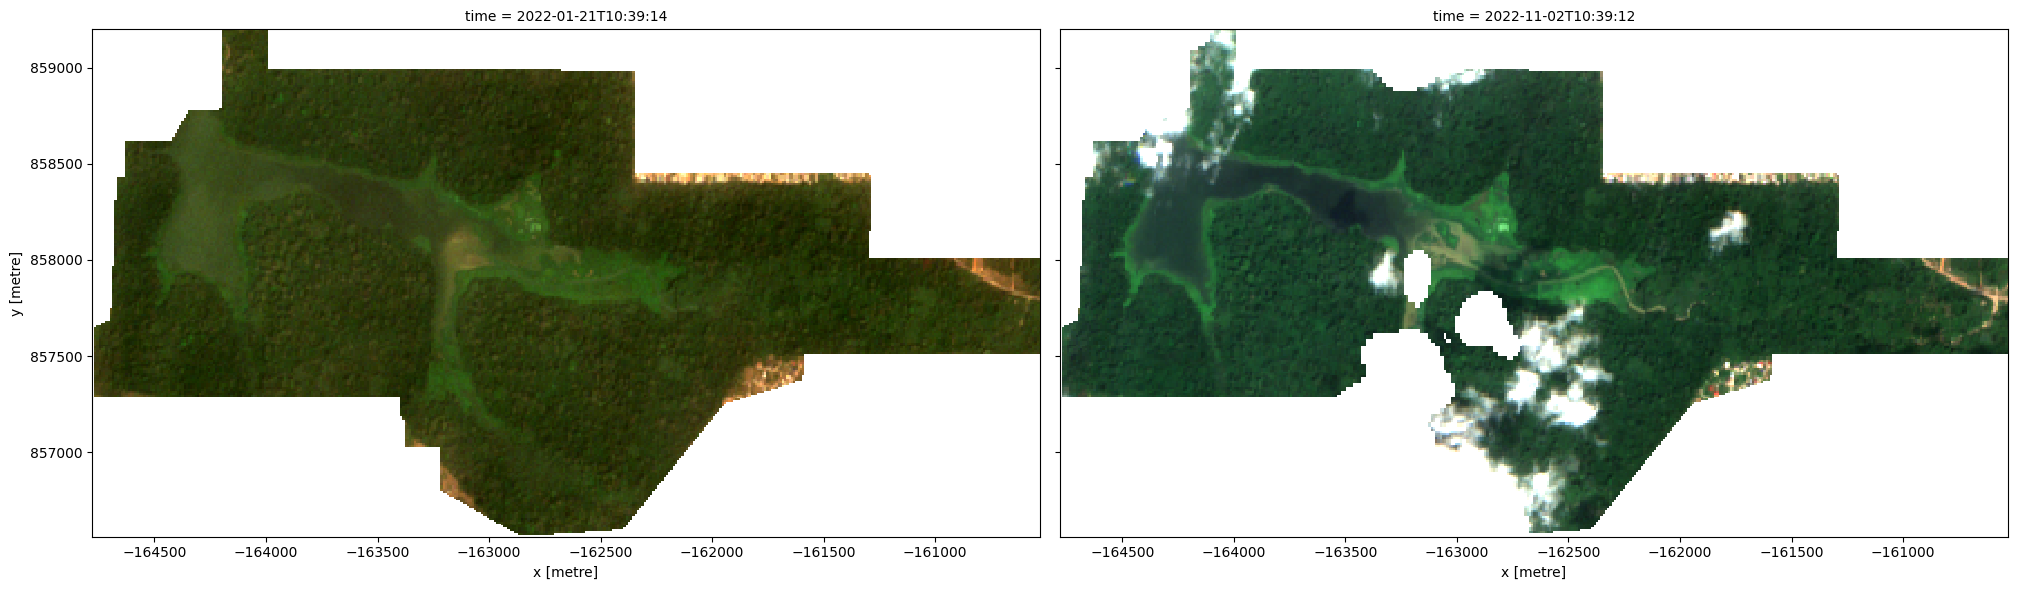

In [14]:
# Set the timesteps to visualise
initial_timestep = 1
final_timestep = 25

# Generate RGB plots at each timestep
rgb(sentinel_2_ds, index=[initial_timestep, final_timestep],
    percentile_stretch=[0.01, 0.99])

## Compute band indices
This study measures the presence of water through the modified normalised difference water index (MNDWI) and clorophyll-*a* through the normalised difference clorophyll index (NDCI).

MNDWI is calculated from the green and shortwave infrared (SWIR) bands to identify water.
The formula is

$$
\begin{aligned}
\text{MNDWI} = \frac{\text{Green} - \text{SWIR}}{\text{Green} + \text{SWIR}}.
\end{aligned}
$$

When interpreting this index, values greater than 0 indicate water.

NDCI is calculated from the red edge 1 and red bands to identify water. [Mishra and Mishra (2012)](https://doi.org/10.1016/j.rse.2011.10.016)
The formula is

$$
\begin{aligned}
\text{NDCI} = \frac{\text{Red edge 1} - \text{Red}}{\text{Red edge 1} + \text{Red}}.
\end{aligned}
$$

When interpreting this index, high values indicate the presence of clorophyll-*a*.

Both indices are available through the [calculate_indices](../Frequently_used_code/Calculating_band_indices.ipynb) function, imported from [deafrica_tools.bandindices](https://docs.digitalearthafrica.org/en/latest/sandbox/gen/deafrica_tools.bandindices.html).
Here, we use `collection="s2"` since we're working with Sentinel-2 data.

In [15]:
# Calculate MNDWI and add it to the loaded data set
sentinel_2_ds = calculate_indices(sentinel_2_ds, index="MNDWI", collection="s2")

# Calculate NDCI and add it to the loaded data set
sentinel_2_ds = calculate_indices(sentinel_2_ds, index="NDCI", collection="s2")

The MNDWI and NDCI values should now appear as data variables, along with the loaded measurements, in the ds data set. Check this by printing the data set below:

In [16]:
sentinel_2_ds

<xarray.Dataset>
Dimensions:      (time: 8, y: 264, x: 425)
Coordinates:
  * time         (time) datetime64[ns] 2022-01-06T10:39:10 ... 2022-11-02T10:...
  * y            (y) float64 8.592e+05 8.592e+05 ... 8.566e+05 8.566e+05
  * x            (x) float64 -1.648e+05 -1.648e+05 ... -1.605e+05 -1.605e+05
    spatial_ref  int32 6933
Data variables:
    red_edge_1   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    red          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    blue         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nir          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    swir_1       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    MNDWI        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    NDCI         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

## Build summary plot
To get an understanding of how the waterbody has changed over time, the following section builds a plot that uses the MNDWI to measure the rough area of the waterbody, along with the NDCI to track how the concentration of clorophyll-*a* is changing over time.
This could be used to quickly assess the status of a given waterbody.

### Set up constants
The number of pixels classified as water (MNDWI > 0) can be used as a proxy for the area of the waterbody if the pixel area is known. 
Run the following cell to generate the necessary constants for performing this conversion.

In [17]:
# Constants for calculating waterbody area
pixel_length = query["resolution"][1]  # in metres
m_per_ha = 100  # conversion from metres to hectares

area_per_pixel = pixel_length**2 / m_per_ha**2

### Compute the total water area
The next cell starts by filtering the data set to only keep the pixels that are classified as water. 
It then calculates the water area by counting all of the MNDWI pixels in the filtered data set, calculating a rolling median (this helps smooth the results to account for variation from cloud-masking), then multiplies this median count by the area-per-pixel.

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

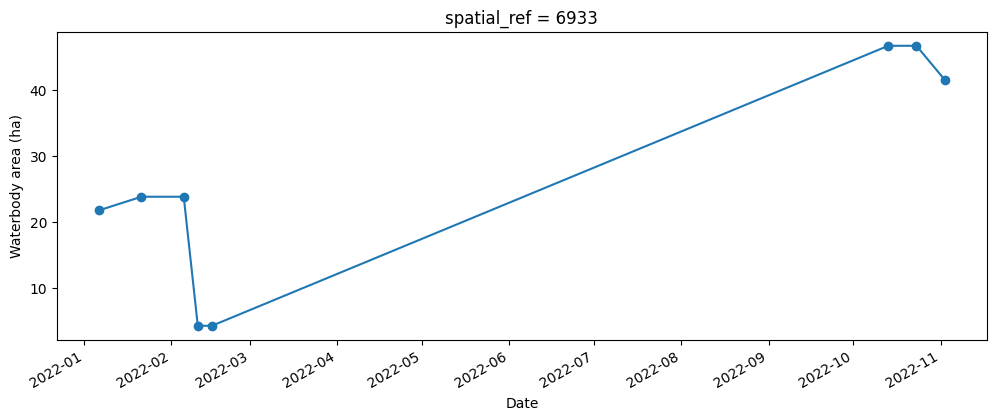

In [18]:
# Filter the data to contain only pixels classified as water
sentinel_2_ds_waterarea = sentinel_2_ds.where(sentinel_2_ds.MNDWI > 0.0)

# Calculate the total water area (in ha)
waterarea = (
    sentinel_2_ds_waterarea.MNDWI.count(dim=["x", "y"])
    .rolling(time=3, center=True, min_periods=1)
    .median(skipna=True)
    * area_per_pixel
).persist()

# Plot the resulting water area through time
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
waterarea.plot.line(marker='o')
axes.set_xlabel("Date")
axes.set_ylabel("Waterbody area (ha)")
plt.show()

calculating MNDWI seasonal medians...


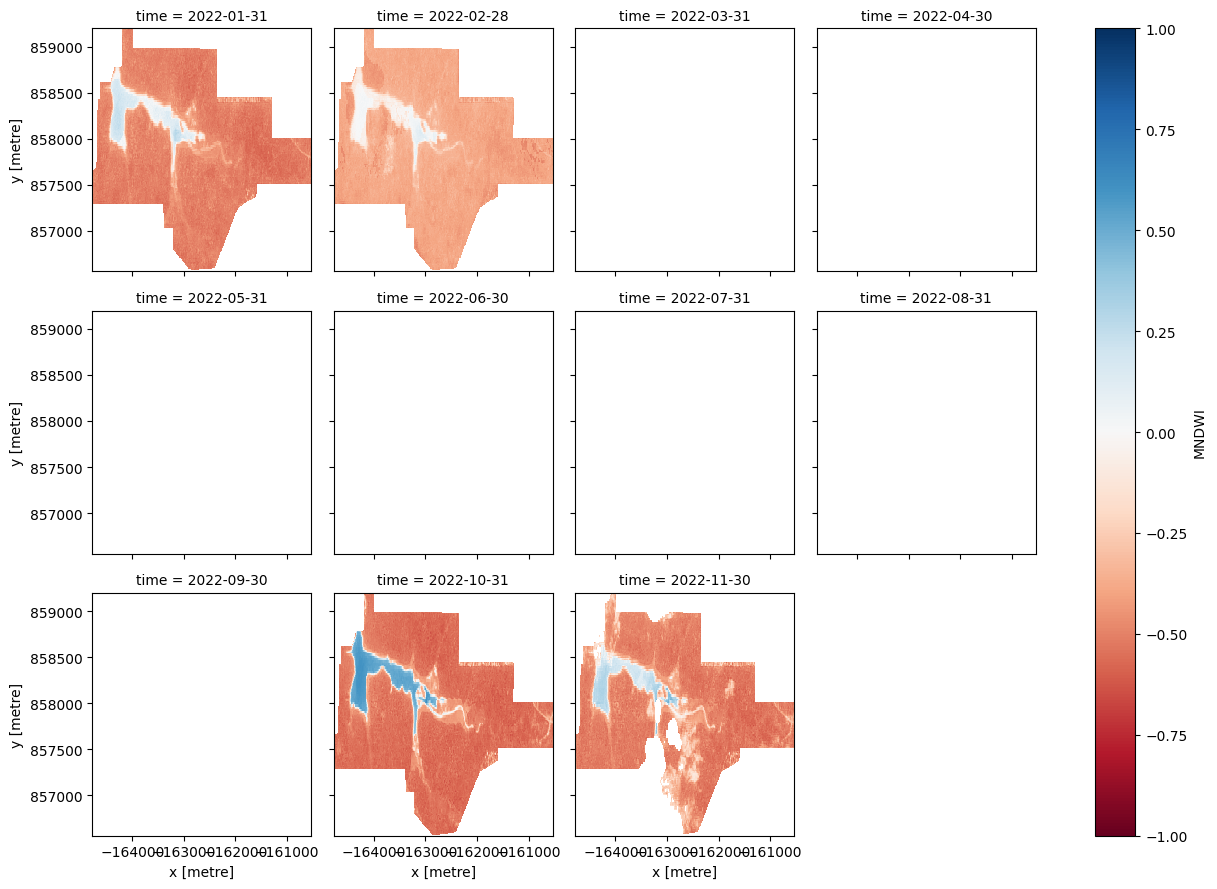

In [19]:
#%%time

#resample using medians
print('calculating MNDWI seasonal medians...')
MNDWI = sentinel_2_ds['MNDWI'].resample(time=sample_frequency).median().compute()
MNDWI.plot(col='time', col_wrap=4, cmap='RdBu', vmax=1, vmin=-1);

### Compute the average NDCI
The next cell computes the average NDCI for each time step using the filtered data set.
This means that we're only tracking the NDCI in waterbody areas, and not on any land.
To make the summary plot, we calculate NDCI across all pixels; this allows us to track overall changes in NDCI, but doesn't tell us where the increase occured within the waterbody (this is covered in the next section).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

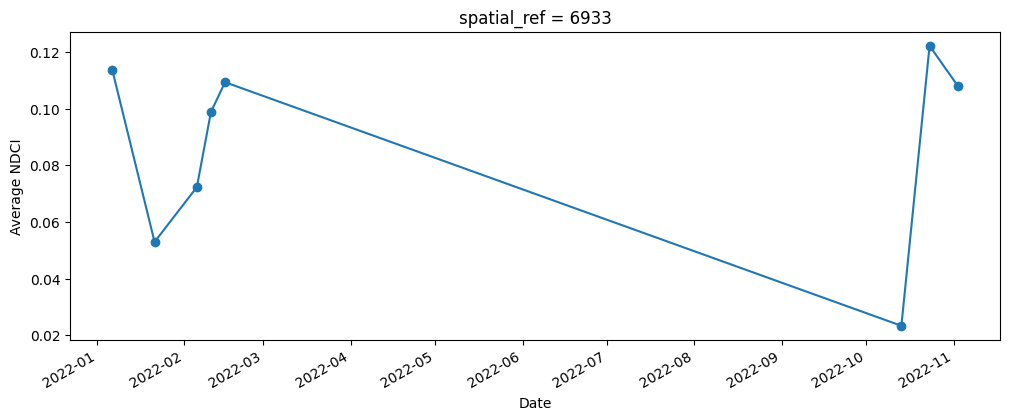

In [20]:
# Calculate the average NDCI
average_ndci = sentinel_2_ds_waterarea.NDCI.mean(dim=["x", "y"], skipna=True).persist()

# Plot average NDCI through time
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
#average_ndci.plot(linestyle=":", marker="s", color="k")
average_ndci.plot.line(marker='o')
axes.set_xlabel("Date")
axes.set_ylabel("Average NDCI")
plt.show()

calculating NDCI seasonal mean...


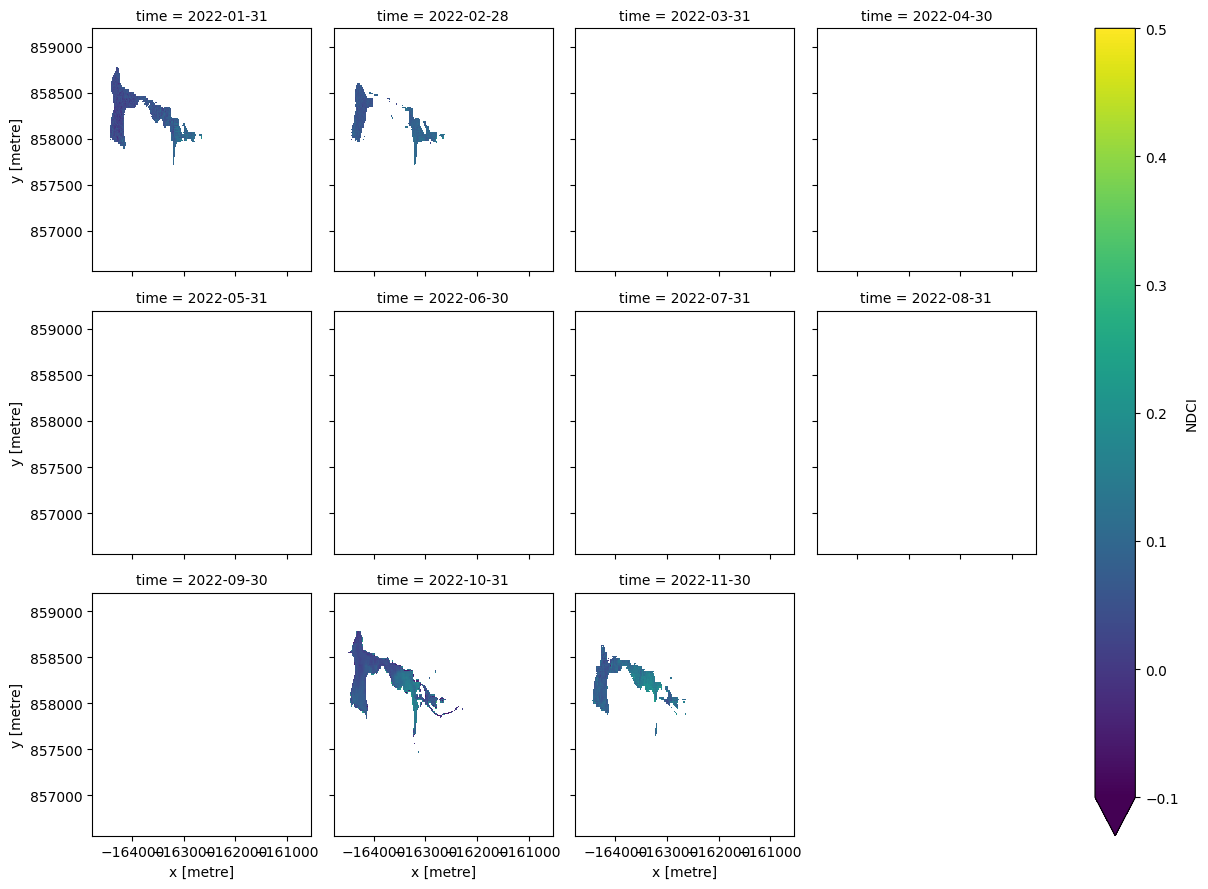

In [21]:
print('calculating NDCI seasonal mean...')
NDCI = sentinel_2_ds_waterarea.NDCI.resample(time=sample_frequency).mean().compute()
NDCI.plot(col='time', col_wrap=4, cmap='viridis', vmax=0.5, vmin=-0.1); #vmax=0.1, vmin=-0.1)

### Combine the data to build the summary plot
The cell below combines the total water area and average NDCI time series we generated above into a single summary plot. 
Notice that Python can be used to build highly-customised plots.
If you're interested, take some time to understand how the plot is built.
Otherwise, run the cell to build the plot.

> **Note**: The colour map used below is normalised so that the maximum `NDCI` value is 0.5, which is thought to correspond to a severe algal bloom event [(Mishra and Mishra 2012)](https://doi.org/10.1016/j.rse.2011.10.016). 
The minimum `NDCI` value of -0.1 corresponds to low conentrations of chlorophyll-*a*.
This makes it more straightforward to identify severe algal bloom events in the plot.

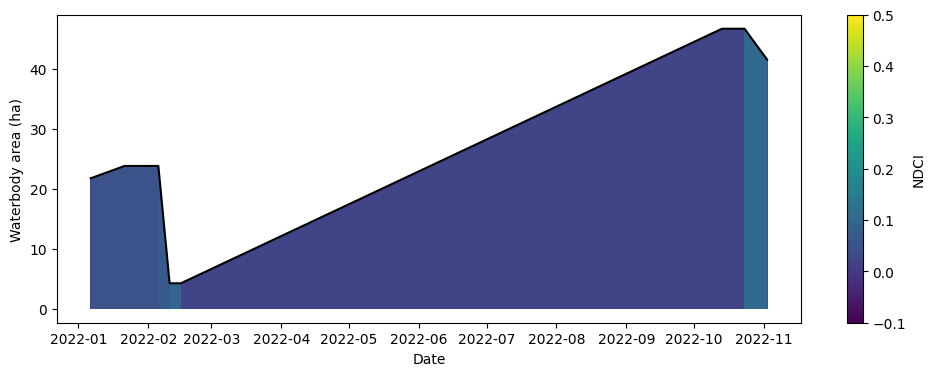

In [22]:
# Set up the figure
fig, axes = plt.subplots(1, 1, figsize=(12, 4))

# Set the colour map to use and the normalisation. NDCI is plotted on a scale
# of -0.1 to 0.5 so the colour map is normalised to these values
min_ndci_scale = -0.1
max_ndci_scale = 0.5
cmap = plt.get_cmap("viridis") # ("cividis")
normal = plt.Normalize(vmin=min_ndci_scale, vmax=max_ndci_scale)

# Store the dates from the data set as numbers for ease of plotting
dates = matplotlib.dates.date2num(sentinel_2_ds_waterarea.time.values)

# Add the basic plot to the figure
# This is just a line showing the area of the waterbody over time
axes.plot_date(x=dates, y=waterarea, color="black", linestyle="-", marker="")

# Fill in the plot by looping over the possible threshold values and filling
# the areas that are greater than the threshold
color_vals = np.linspace(0, 1, 100)
threshold_vals = np.linspace(min_ndci_scale, max_ndci_scale, 100)
for ii, thresh in enumerate(threshold_vals):
    im = axes.fill_between(dates,
                           0,
                           waterarea,
                           where=(average_ndci >= thresh),
                           norm=normal,
                           facecolor=cmap(color_vals[ii]),
                           alpha=1)

# Add the colour bar to the plot
cax, _ = matplotlib.colorbar.make_axes(axes)
cb2 = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normal)
cb2.set_label("NDCI")

# Add titles and labels to the plot
axes.set_xlabel("Date")
axes.set_ylabel("Waterbody area (ha)")
plt.show()

In [23]:
LOW = NDCI.mean(dim=["time"]).mean(dim=["x", "y"]) - NDCI.std()
Medium = NDCI.mean(dim=["time"]).mean(dim=["x", "y"]) + NDCI.std()

In [24]:
NDCI_1 = NDCI.mean('time')
NDCI_1

<xarray.DataArray 'NDCI' (y: 264, x: 425)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y            (y) float64 8.592e+05 8.592e+05 ... 8.566e+05 8.566e+05
  * x            (x) float64 -1.648e+05 -1.648e+05 ... -1.605e+05 -1.605e+05
    spatial_ref  int32 6933

In [25]:
#Classify the NDTI into 3 classes.
#Define the Labels and class values.
NDCI_class_labels = ["LOW", "Medium", "High"]

NDCI_classes = [1, 2, 3]

#Define the colors to be used to represent the NDTI classes. 
NDCI_colors = ["yellow", "orange", "green"]

classification_condition = [NDCI_1 <= LOW,
                            (NDCI_1>LOW) & (NDCI_1<= Medium), 
                            NDCI_1 > Medium]
                          

NDCI_classified = xr.DataArray (data=np.select (classification_condition, NDCI_classes, default=np.nan),
                                coords={"y": NDCI_1.y, "x": NDCI_1.x},
                                dims=["y", "x"]).astype(NDCI_1.dtype).where(mask)

NDCI_classified

<xarray.DataArray (y: 264, x: 425)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y        (y) float64 8.592e+05 8.592e+05 8.592e+05 ... 8.566e+05 8.566e+05
  * x        (x) float64 -1.648e+05 -1.648e+05 ... -1.605e+05 -1.605e+05

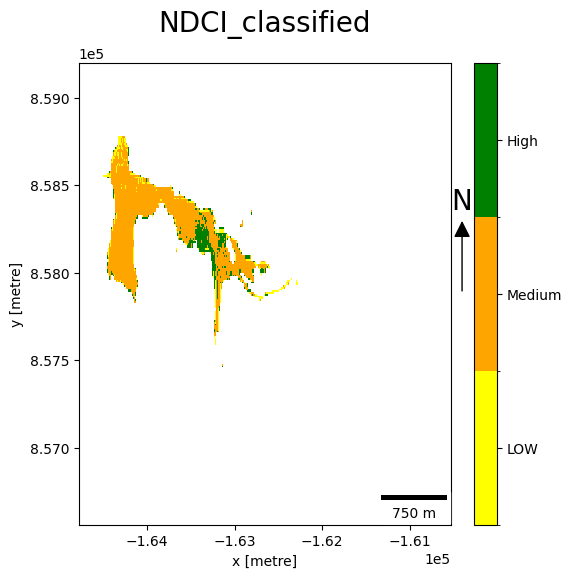

In [26]:
plt.rcParams.update({'font.size': 10})

# Define the color map to use to plot the change detection xarray.DataArray
cmap = mcolors.ListedColormap(colors=NDCI_colors, N=len(NDCI_classes))
bounds = np.arange(min(NDCI_classes) - 0.5, max(NDCI_classes) + 1, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the change detection xarray.DataArray.
fig , ax = plt.subplots(figsize=(6, 6))
im = NDCI_classified.plot.imshow(add_colorbar=False, ax=ax, cmap=cmap, norm=norm)
# Type of notation on the axes.
ax.ticklabel_format(axis="both", style='scientific', scilimits=(0, 0))
# Add a scale bar.
ax.add_artist(ScaleBar(dx=1, location="lower right"))
# Add a north arrow to the plot. 
x, y, arrow_length = 1.03, 0.5, 0.2
ax.annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
            arrowprops=dict(arrowstyle='<|-, head_length=0.5, head_width=0.25', facecolor='black'),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

plt.title(f"NDCI_classified", y=1.05, ha="center", size=20)

# Color bar.
cbar = plt.colorbar(im, ticks=NDCI_classes)
cbar.set_ticklabels(NDCI_class_labels)
cbar.ax.tick_params(labelsize=10)
plt.show()    

##  Normalized Difference Turbidity Index

Paper: [Lacaux et al 2007](https://www.researchgate.net/publication/223596486_Classification_of_Ponds_from_High-Spatial_Resolution_Remote_Sensing_Application_to_Rift_Valley_Fever_Epidemics_in_Senegal)

$$
NDTI = \frac{\text{Red}-\text{Green}}{\text{Red}+\text{Green}}
$$

In [27]:
# Function to calculate NDTI value
def NDTI(sentinel_2_ds):
    return (sentinel_2_ds.red - sentinel_2_ds.green) / (sentinel_2_ds.red + sentinel_2_ds.green)

In [28]:
# Calculate the NDTI value for Sentinel 2, using water extent to mask
ndti = NDTI(sentinel_2_ds_waterarea)

### Compute the average NDTI

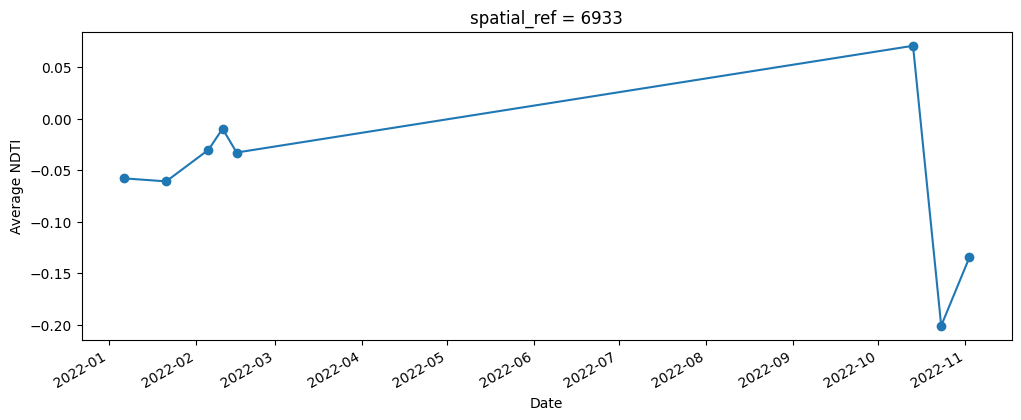

In [29]:
# Calculate the average NDTI
average_ndti = ndti.mean(dim=["x", "y"], skipna=True).persist()

# Plot average NDTI through time
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
#average_ndci.plot(linestyle=":", marker="s", color="k")
average_ndti.plot.line(marker='o')
axes.set_xlabel("Date")
axes.set_ylabel("Average NDTI")
plt.show()

calculating NDTI seasonal mean...


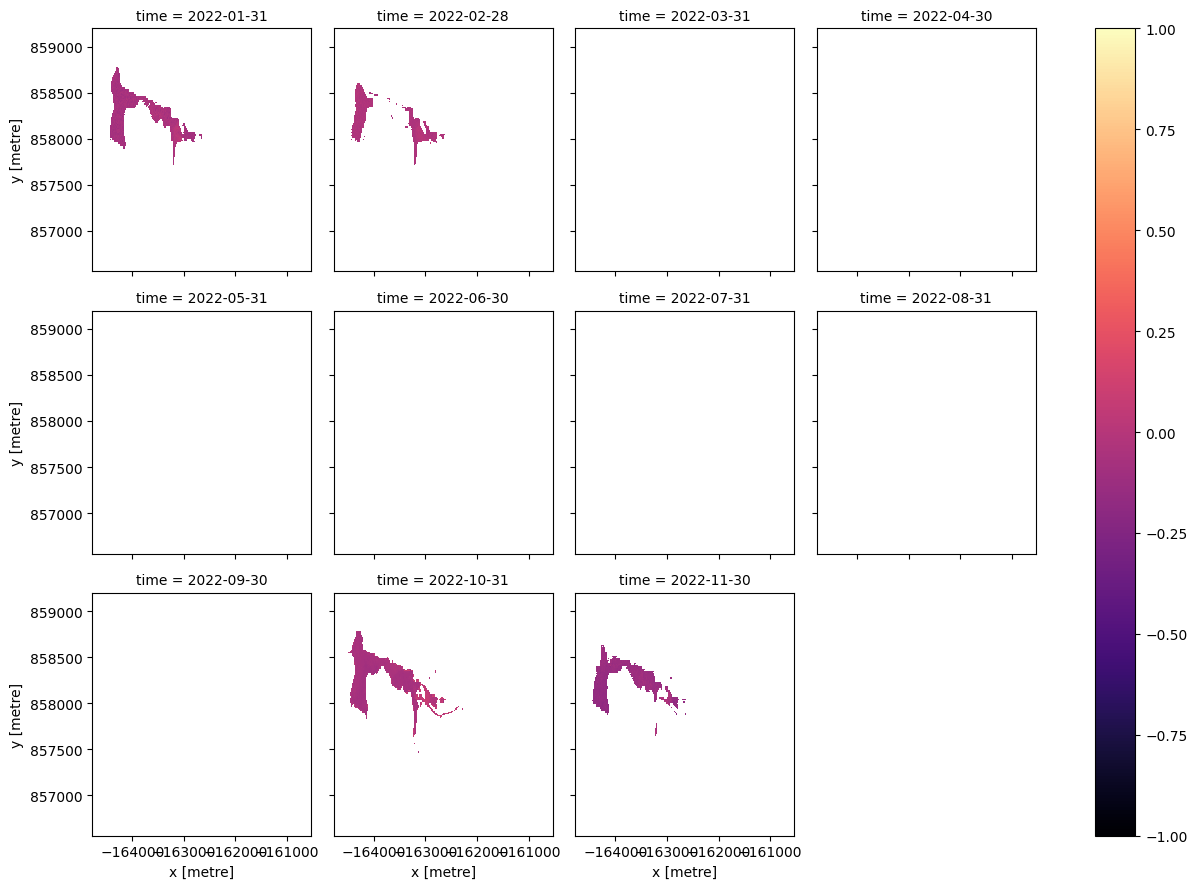

In [30]:
print('calculating NDTI seasonal mean...')
ndti = ndti.resample(time=sample_frequency).mean().compute()
ndti.plot(col='time', col_wrap=4, cmap='magma', vmax=1, vmin=-1); #vmax=1, vmin=-1

### Combine the data to build the summary plot

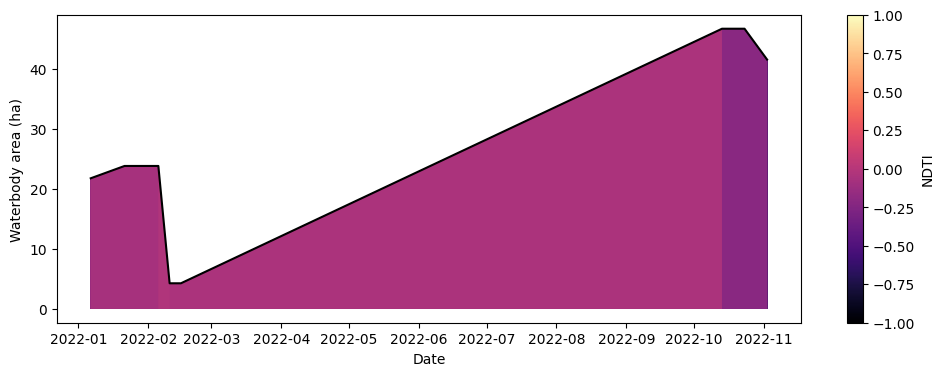

In [31]:
# Set up the figure
fig, axes = plt.subplots(1, 1, figsize=(12, 4))

# Set the colour map to use and the normalisation. NDTI is plotted on a scale
# of -0.1 to 0.5 so the colour map is normalised to these values
min_ndti_scale = -1
max_ndti_scale = 1
cmap = plt.get_cmap("magma") # ("cividis")
normal = plt.Normalize(vmin=min_ndti_scale, vmax=max_ndti_scale)

# Store the dates from the data set as numbers for ease of plotting
dates = matplotlib.dates.date2num(sentinel_2_ds_waterarea.time.values)

# Add the basic plot to the figure
# This is just a line showing the area of the waterbody over time
axes.plot_date(x=dates, y=waterarea, color="black", linestyle="-", marker="")

# Fill in the plot by looping over the possible threshold values and filling
# the areas that are greater than the threshold
color_vals = np.linspace(0, 1, 100)
threshold_vals = np.linspace(min_ndti_scale, max_ndti_scale, 100)
for ii, thresh in enumerate(threshold_vals):
    im = axes.fill_between(dates,
                           0,
                           waterarea,
                           where=(average_ndti >= thresh),
                           norm=normal,
                           facecolor=cmap(color_vals[ii]),
                           alpha=1)

# Add the colour bar to the plot
cax, _ = matplotlib.colorbar.make_axes(axes)
cb2 = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normal)
cb2.set_label("NDTI")

# Add titles and labels to the plot
axes.set_xlabel("Date")
axes.set_ylabel("Waterbody area (ha)")
plt.show()

### Classify the NDTI into 3 classes "LOW", "Medium", "High"

In [32]:
LOW = ndti.mean(dim=["time"]).mean(dim=["x", "y"]) - ndti.std()
Medium = ndti.mean(dim=["time"]).mean(dim=["x", "y"]) + ndti.std()

In [33]:
ndti_1 = ndti.mean('time')
ndti_1

<xarray.DataArray (y: 264, x: 425)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y            (y) float64 8.592e+05 8.592e+05 ... 8.566e+05 8.566e+05
  * x            (x) float64 -1.648e+05 -1.648e+05 ... -1.605e+05 -1.605e+05
    spatial_ref  int32 6933

In [34]:
#Classify the NDTI into 3 classes.
#Define the Labels and class values.
ndti_class_labels = ["LOW", "Medium", "High"]

ndti_classes = [1, 2, 3]

#Define the colors to be used to represent the NDTI classes. 
ndti_colors = ["#a50026", "#f88d52", "#ffffbf"] 
classification_condition = [ndti_1 <= LOW,
                            (ndti_1>LOW) & (ndti_1<= Medium), 
                            ndti_1 > Medium]
                          

ndti_classified = xr.DataArray (data=np.select (classification_condition, ndti_classes, default=np.nan),
                                coords={"y": ndti_1.y, "x": ndti_1.x},
                                dims=["y", "x"]).astype(ndti_1.dtype).where(mask)

ndti_classified

<xarray.DataArray (y: 264, x: 425)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y        (y) float64 8.592e+05 8.592e+05 8.592e+05 ... 8.566e+05 8.566e+05
  * x        (x) float64 -1.648e+05 -1.648e+05 ... -1.605e+05 -1.605e+05

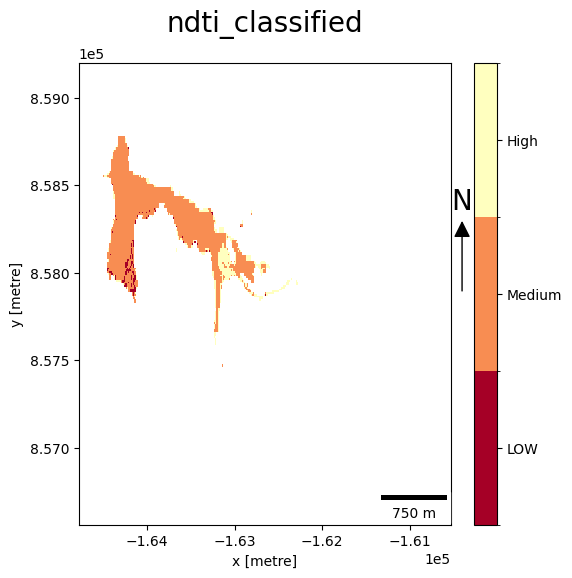

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [35]:
plt.rcParams.update({'font.size': 10})

# Define the color map to use to plot the change detection xarray.DataArray
cmap = mcolors.ListedColormap(colors=ndti_colors, N=len(ndti_classes))
bounds = np.arange(min(ndti_classes) - 0.5, max(ndti_classes) + 1, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the change detection xarray.DataArray.
fig , ax = plt.subplots(figsize=(6, 6))
im = ndti_classified.plot.imshow(add_colorbar=False, ax=ax, cmap=cmap, norm=norm)
# Type of notation on the axes.
ax.ticklabel_format(axis="both", style='scientific', scilimits=(0, 0))
# Add a scale bar.
ax.add_artist(ScaleBar(dx=1, location="lower right"))
# Add a north arrow to the plot. 
x, y, arrow_length = 1.03, 0.5, 0.2
ax.annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
            arrowprops=dict(arrowstyle='<|-, head_length=0.5, head_width=0.25', facecolor='black'),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

plt.title(f"ndti_classified", y=1.05, ha="center", size=20)

# Color bar.
cbar = plt.colorbar(im, ticks=ndti_classes)
cbar.set_ticklabels(ndti_class_labels)
cbar.ax.tick_params(labelsize=10)
plt.show()    